<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project2/blob/master/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

In [1]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 1.2MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 1.9MB/s 
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100


In [0]:
ROOT_DIRECTORY = '.'

In [5]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# IMPORTS

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random

import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder

# HYPERPARAMETERS

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DATA LOADING AND TRANSFORMATION

In [0]:
SOURCE_FOLDER = '{}/data/Task2/Source'.format(ROOT_DIRECTORY)
TARGET_FOLDER = '{}/data/Task2/Target'.format(ROOT_DIRECTORY)

In [0]:
# Custom image folder for unlabeled target folder.

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def has_file_allowed_extension(filename, extensions):
    return filename.lower().endswith(extensions)

def make_dataset(dir, extensions=None, is_valid_file=None):
  """
  Adaption of https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
  """
  images = []
  dir = os.path.expanduser(dir)
  if not ((extensions is None) ^ (is_valid_file is None)):
    raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
  if extensions is not None:
    def is_valid_file(x):
      return has_file_allowed_extension(x, extensions)
  for root, _, fnames in sorted(os.walk(dir)):
    for fname in sorted(fnames):
      path = os.path.join(root, fname)
      if is_valid_file(path):
        images.append(path)

  return images

def pil_loader(path):
  # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
  with open(path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
    return img

def accimage_loader(path):
  import accimage
  try:
    return accimage.Image(path)
  except IOError:
    # Potentially a decoding problem, fall back to PIL.Image
    return pil_loader(path)

def default_loader(path):
  from torchvision import get_image_backend
  if get_image_backend() == 'accimage':
    return accimage_loader(path)
  else:
    return pil_loader(path)


class TargetImageFolder(Dataset):

  def __init__(self, root, loader, extensions=None, transform=None):
    self.extensions = extensions
    self.loader = loader
    self.samples = make_dataset(root, extensions=IMG_EXTENSIONS)
    self.transform = transform

  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self, index):
    path = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
      sample = self.transform(sample)
    return sample

In [0]:
SOURCE_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
TARGET_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

source_transform = transforms.Compose([
                                       transforms.RandomResizedCrop(227),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])

target_transform = transforms.Compose([
                                       transforms.Resize((227, 227)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])

source_set = ImageFolder(SOURCE_FOLDER, transform=source_transform)

target_set = TargetImageFolder(TARGET_FOLDER, default_loader, transform=target_transform, extensions=IMG_EXTENSIONS)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Source Samples
  mug paper_notebook back_pack speaker   mug   pen printer paper_notebook back_pack monitor paper_notebook printer   mug speaker


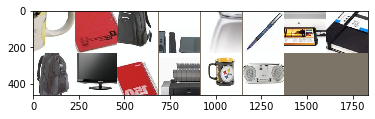

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ---- Target Samples


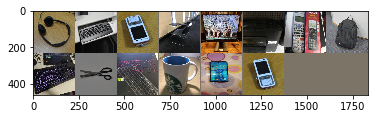

In [40]:
def unnormalize(x, mean, std):
  x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
  return x

def showimg(tensor, normalization=None):
    # tensor = tensor / 2 + 0.5     # unnormalize, because normalization is (img - 0.5)/0.5 in transforms.Normalize
    npimg = tensor.numpy()
    if normalization:
      npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Samples dataloaders
source_loader = DataLoader(source_set, batch_size=14, shuffle=True, num_workers=1)

target_loader = DataLoader(target_set, batch_size=14, shuffle=True, num_workers=1)


# Source Sample
dataiter = source_loader.__iter__()
input, labels = dataiter.next()
print(' ---- Source Samples')
print(' '.join('%5s' % source_set.classes[labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(input), SOURCE_NORMALIZATION)

# Target Sample
dataiter = target_loader.__iter__()
input = dataiter.next()
print(' ---- Target Samples')
showimg(torchvision.utils.make_grid(input), TARGET_NORMALIZATION)

# MODEL STRUCTURE



*   https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
*   https://github.com/wogong/pytorch-dann



In [52]:
class Reverse(torch.autograd.Function):

  @staticmethod
  def forward(ctx, x, lbd):
    ctx.lbd = lbd
    return x.view_as(x)
  
  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.lbd
    return output, None


class DANN(nn.Module):

  def __init__(self, number_classes=10):
    super(DANN, self).__init__()

    model_alexnet = torchvision.models.alexnet(pretrained=True)

    self.features = model_alexnet.features

    self.fc = model_alexnet.classifier[:-1] # Remove last layer
    bottleneck_features = model_alexnet.classifier[-1].in_features

    self.bottleneck = nn.Sequential(
      nn.Linear(bottleneck_features, int(bottleneck_features / 2)),
      nn.ReLU(inplace=True),
    )

    self.class_classifier = nn.Sequential(
      nn.Linear(int(bottleneck_features / 2), number_classes)
    )

    self.domain_classifier = nn.Sequential(
      nn.Linear(int(bottleneck_features / 2), 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 1024),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(1024, 2),
    )

  def forward(self, input, lbd=0.1):
    features = self.features(input)
    features = features.view(-1, 256*6*6)
    fc = self.fc(features)
    bottleneck = self.bottleneck(fc)
    reverse_bottleneck = Reverse.apply(bottleneck, lbd)

    predicted_classes = self.class_classifier(bottleneck)
    predicted_domains = self.domain_classifier(reverse_bottleneck)

    return predicted_classes, predicted_domains

dann_test = DANN().to(device)
INPUT_SIZE = (3, 227, 227)
input_random = torch.rand((1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2])).to(device)
print(dann_test(input_random))

torch.Size([1, 256, 6, 6])
(tensor([[-0.2162,  0.0291, -0.0972,  0.0406, -0.0317, -0.0982, -0.3928,  0.2126,
          0.0906, -0.0048]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([[-0.0042,  0.0069]], device='cuda:0', grad_fn=<AddmmBackward>))
